In [216]:
import pandas as pd
import random
import matplotlib.pyplot as plt

In [241]:
pd.options.display.max_rows = 11
df = pd.read_csv("rte.standardized.tsv", delimiter="\t", quotechar='"')
#rd = rd.iloc[1: , :]
df = df.drop('!amt_annotation_ids', axis=1)
#print(df)
for index, row in df.iterrows():
    if row['response'] == 0: df.at[index,'response'] = -1
    if row['gold'] == 0: df.at[index,'gold'] = -1
print(df)

     !amt_worker_ids  orig_id  response  gold
0     A19IBSKBTABMR3      266         1     1
1      AEX5NCH03LWSG      266         1     1
2     A17RPF5ZMO75GW      266         1     1
3     A15L6WGIK3VU7N      266        -1     1
4     A3U7T47F498T1P      266         1     1
...              ...      ...       ...   ...
7995  A17HNBZF5A1CWF      605         1     1
7996  A11GX90QFWDLMM      605        -1     1
7997  A1Q4VUJBMY78YR      605         1     1
7998  A1CP0KZJS5LSIF      605         1     1
7999  A1ZVGUVI9TAZJX      605         1     1

[8000 rows x 4 columns]


In [258]:
# majority voting to get current_ground_truth
tasks = df.groupby('orig_id')
groundTruth = {}
for groupName in tasks.groups.keys():
    lables = [0,1,2,3,4,5,6,7,8,9]
    group = tasks.get_group(groupName)
    response = group['response']

    #print(groupName,":")
    #print(response.iloc[0])
    count_1 = 0
    count_0 = 0
    for lable in lables:
        #print(response.iloc[lable], "--", valid.iloc[lable])
        if response.iloc[lable] == 1:
            count_1 += 1
        else:
            count_0 += 1

    if count_1 > count_0:
        groundTruth[groupName] = 1
    elif count_1 < count_0:
        groundTruth[groupName] = -1
    elif count_1 == count_0:
        lables = set([-1, 1])
        pick = random.sample([*lables], k=1)
        groundTruth[groupName] = list(pick)[0]

In [243]:
def sampling(df, k):
    tasks = df.groupby('orig_id')
    
    column_names = ["!amt_worker_ids", "orig_id", "response", "gold"]

    row_list = []
    for groupName in tasks.groups.keys():
        task = tasks.get_group(groupName)
        lables = set([0,1,2,3,4,5,6,7,8,9])
        pick = random.sample([*lables], k=k)
        for lable in pick:
            dic = {'!amt_worker_ids': task.iloc[lable, 0],
                   'orig_id': task.iloc[lable, 1],
                   'response': task.iloc[lable, 2],
                   'gold': task.iloc[lable, 3]
                  }
            row_list.append(dic)
    newDf = pd.DataFrame(row_list)
    return newDf

In [244]:
def getQuality(df, groundTruth):   
    quality = {}
    workers = df.groupby('!amt_worker_ids')
    for worker in workers.groups.keys():
        works = workers.get_group(worker)
        #print(works)
        total = 0
        correct = 0
        for index, row in works.iterrows():
            total += 1
            if row['response'] == groundTruth[row['orig_id']] : correct += 1
        quality[worker] = float(correct)/total
        #print(correct,"--", total)
    
    return quality
    # Use current_ground_truth to calculate Qualities of worker, build a worker dic
    

In [245]:
#quality = getQuality(df, groundTruth)
#print(quality)

In [246]:
def getGroundTruth(df, quality, groundTruth):
    tasks = df.groupby('orig_id')
    newGroundTruth = {}
    for groupName in tasks.groups.keys():
        group = tasks.get_group(groupName)
        sum = 0
        for index, row in group.iterrows():
            sum += quality[row['!amt_worker_ids']] * row['response']  
        if sum > 0:
            newGroundTruth[groupName] = 1
        elif sum < 0:
            newGroundTruth[groupName] = -1
        else:
            lables = set([-1, 1])
            pick = random.sample([*lables], k=1)
            newGroundTruth[groupName] = list(pick)[0]
    return newGroundTruth

In [247]:
#groundTruth = getGroundTruth(df, quality, groundTruth)
#print(groundTruth)

In [248]:
def getError(df, groundTruth):
    tasks = df.groupby('orig_id')
    error = 0
    total = 0
    for groupName in tasks.groups.keys():
        total += 1
        task = tasks.get_group(groupName)
        if groundTruth[groupName] != task.iloc[0, 3]:
            error += 1
    print(error, "--", total)
    return float(error)/total

In [256]:
quality = {}
dic = {1:0, 2:0, 3:0, 4:0, 5:0, 6:0, 7:0, 8:0, 9:0, 10:0}
for t in range(1, 11): 
    for k in range(1, 11):
        print("k=",k)
        sample = sampling(df, k)
        for i in range(0, 100):
            print("Iteration:",i)
            quality = getQuality(sample, groundTruth)
            newGroundTruth = getGroundTruth(sample, quality, groundTruth)
            if newGroundTruth == groundTruth:
                print("End")
                break
            groundTruth = newGroundTruth
        dic[k] += getError(sample, groundTruth)
for i in range(1, 11):
    dic[i] = dic[i]/float(10)
print(dic)

k= 1
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
End
217 -- 800
k= 2
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
End
153 -- 800
k= 3
Iteration: 0
Iteration: 1
Iteration: 2
End
168 -- 800
k= 4
Iteration: 0
Iteration: 1
Iteration: 2
End
101 -- 800
k= 5
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
End
125 -- 800
k= 6
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
End
90 -- 800
k= 7
Iteration: 0
Iteration: 1
Iteration: 2
End
79 -- 800
k= 8
Iteration: 0
Iteration: 1
Iteration: 2
End
77 -- 800
k= 9
Iteration: 0
Iteration: 1
Iteration: 2
End
67 -- 800
k= 10
Iteration: 0
Iteration: 1
End
62 -- 800
k= 1
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
End
210 -- 800
k= 2
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
End
176 -- 800
k= 3
Iteration: 0
Iteration: 1
Iteration: 2
End
157 -- 800
k= 4
Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
End
114 -- 800
k= 5
Iteration: 0
Iteration: 1
Iteration: 2
Iter

{1: 0.275, 2: 0.20787499999999998, 3: 0.201, 4: 0.13087500000000002, 5: 0.14550000000000002, 6: 0.11099999999999999, 7: 0.10187499999999998, 8: 0.09275, 9: 0.08349999999999999, 10: 0.077625}


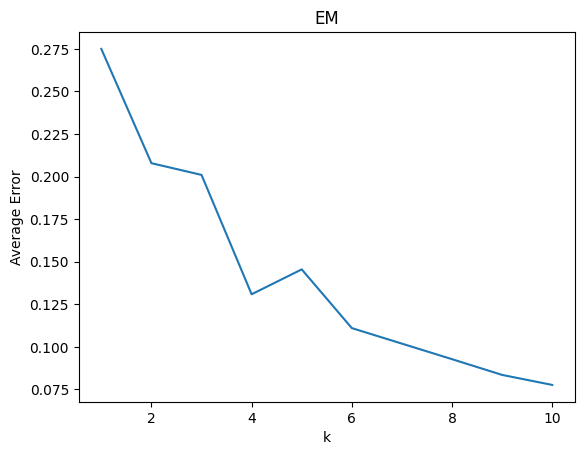

In [257]:
print(dic)
plt.plot(dic.keys(), dic.values())
plt.ylabel('Average Error')
plt.xlabel('k')
plt.title('EM')
plt.show()

In [ ]:
mv = {1: 0.25625, 2: 0.2525, 3: 0.19625, 4: 0.19375, 5: 0.145, 6: 0.14875, 7: 0.1175, 8: 0.12, 9: 0.10375, 10: 0.09125}
em = {1: 0.2775, 2: 0.22125, 3: 0.21, 4: 0.13875, 5: 0.14125, 6: 0.11375, 7: 0.10125, 8: 0.09625, 9: 0.07875, 10: 0.07625}